# 01 - The Problem: Why Casys MCP Gateway Exists

Before learning how the gateway works, let's **experience the problems it solves**.

## Learning Objectives

After this notebook, you will:

- [ ] See how tool schemas consume context tokens
- [ ] Measure the latency cost of sequential execution
- [ ] Understand why these problems limit MCP adoption

---

## Problem 1: The Context Explosion

Every MCP tool has a **schema** that describes:

- What the tool does (description)
- What inputs it needs (parameters)
- What it returns (output schema)

When you connect an MCP server, **ALL schemas are loaded** into the LLM context.

Let's simulate what happens:

In [1]:
// Simulate MCP tool schemas (realistic sizes)
const mcpServers = {
  github: {
    tools: 15,
    avgTokensPerTool: 800,
    examples: ["create_issue", "list_commits", "create_pr", "search_code"],
  },
  filesystem: {
    tools: 8,
    avgTokensPerTool: 600,
    examples: ["read_file", "write_file", "list_directory", "search_files"],
  },
  database: {
    tools: 12,
    avgTokensPerTool: 900,
    examples: ["query", "insert", "update", "create_table"],
  },
  playwright: {
    tools: 20,
    avgTokensPerTool: 750,
    examples: ["navigate", "click", "screenshot", "fill_form"],
  },
  slack: {
    tools: 10,
    avgTokensPerTool: 700,
    examples: ["send_message", "search_messages", "list_channels"],
  },
  notion: {
    tools: 14,
    avgTokensPerTool: 850,
    examples: ["create_page", "query_database", "update_block"],
  },
  jira: {
    tools: 16,
    avgTokensPerTool: 820,
    examples: ["create_issue", "search_issues", "update_status"],
  },
  serena: {
    tools: 25,
    avgTokensPerTool: 650,
    examples: ["analyze_code", "find_references", "rename_symbol"],
  },
};

// Calculate total context consumption
const CONTEXT_WINDOW = 200_000; // Claude's context window

let totalTokens = 0;
let totalTools = 0;

console.log("MCP Server Context Consumption\n" + "=".repeat(50));
console.log();

for (const [server, data] of Object.entries(mcpServers)) {
  const serverTokens = data.tools * data.avgTokensPerTool;
  totalTokens += serverTokens;
  totalTools += data.tools;

  const percentage = ((serverTokens / CONTEXT_WINDOW) * 100).toFixed(1);
  console.log(
    `${server.padEnd(12)} ${
      data.tools.toString().padStart(2)
    } tools × ${data.avgTokensPerTool} tokens = ${
      serverTokens.toLocaleString().padStart(6)
    } tokens (${percentage}%)`,
  );
}

console.log("─".repeat(50));
const totalPercentage = ((totalTokens / CONTEXT_WINDOW) * 100).toFixed(1);
console.log(
  `TOTAL:       ${totalTools} tools                   ${
    totalTokens.toLocaleString().padStart(6)
  } tokens (${totalPercentage}%)`,
);
console.log();
console.log(
  `⚠️  ${totalPercentage}% of your context window is consumed BEFORE you even start talking!`,
);

MCP Server Context Consumption

github       15 tools × 800 tokens = 12,000 tokens (6.0%)
filesystem    8 tools × 600 tokens =  4,800 tokens (2.4%)
database     12 tools × 900 tokens = 10,800 tokens (5.4%)
playwright   20 tools × 750 tokens = 15,000 tokens (7.5%)
slack        10 tools × 700 tokens =  7,000 tokens (3.5%)
notion       14 tools × 850 tokens = 11,900 tokens (5.9%)
jira         16 tools × 820 tokens = 13,120 tokens (6.6%)
serena       25 tools × 650 tokens = 16,250 tokens (8.1%)
──────────────────────────────────────────────────
TOTAL:       120 tools                   90,870 tokens (45.4%)

⚠️  45.4% of your context window is consumed BEFORE you even start talking!


### The Impact

With ~45% of context consumed by tool schemas:

- **Long conversations get truncated** - Important context gets dropped
- **Complex tasks fail** - Not enough room for reasoning
- **You self-limit** - "I'll disable that MCP server to save context"

And here's the irony: **You only use 3-5 tools per request**, but you're paying for 120.

In [2]:
// The waste calculation - now with visual metrics
import { progressBar, compareMetrics } from "../lib/metrics.ts";

const TOOLS_USED_PER_REQUEST = 4; // Average tools actually used
// Use dynamic totalTools from previous cell instead of hardcoding
const tokensUsed = TOOLS_USED_PER_REQUEST * (totalTokens / totalTools);

const usageRate = (TOOLS_USED_PER_REQUEST / totalTools * 100).toFixed(1);
const wastedTokens = totalTokens * (1 - TOOLS_USED_PER_REQUEST / totalTools);
const wastedPercentage = (wastedTokens / CONTEXT_WINDOW * 100).toFixed(1);

console.log("The Waste Problem\n" + "=".repeat(50));
console.log();

// Visual progress bar showing context consumption
console.log("Context Window Usage:");
console.log(progressBar(totalTokens, CONTEXT_WINDOW, "consumed by tool schemas"));
console.log();

// Comparison table: loaded vs used
console.log("📊 Token Efficiency Analysis:\n");
console.log(compareMetrics(
  { "Tokens": totalTokens, "Tools": totalTools },
  { "Tokens": Math.round(tokensUsed), "Tools": TOOLS_USED_PER_REQUEST },
  { labels: { before: "Loaded", after: "Actually Used" } }
));
console.log();

console.log(`💸 You're paying for ${totalTools - TOOLS_USED_PER_REQUEST} tools you don't use!`);
console.log(`📉 ${wastedPercentage}% of your context window is wasted!`);

The Waste Problem

Context Window Usage:
[█████████░░░░░░░░░░░] 45% consumed by tool schemas

📊 Token Efficiency Analysis:

──────────────────────────────────────────────────────────
Metric   │       Loaded │ Actually Used │            Delta
──────────────────────────────────────────────────────────
Tokens   │       90,870 │        3,029 │  -87841 (-96.7%)
Tools    │          120 │            4 │    -116 (-96.7%)
──────────────────────────────────────────────────────────

💸 You're paying for 116 tools you don't use!
📉 43.9% of your context window is wasted!


---

## Problem 2: Sequential Latency

Now let's look at the second problem: **every tool call is sequential**.

Consider a simple workflow:

Workflow: Create Jira ticket from config + GitHub + Slack

Note: Steps 3 and 4 are INDEPENDENT - they could run in parallel!



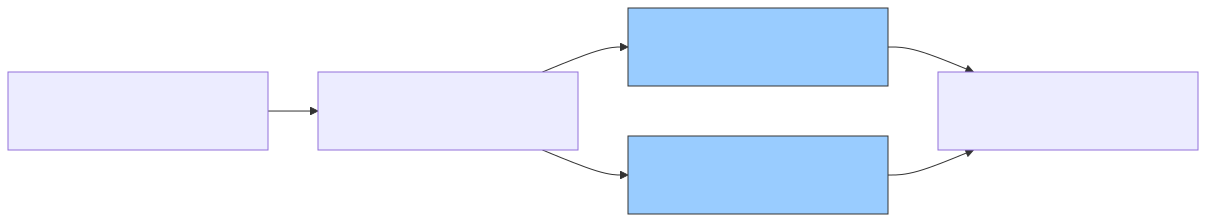

In [3]:
// Simulate a multi-tool workflow
import { displayMermaid } from "../lib/viz.ts";

interface Task {
  name: string;
  duration: number; // ms
  dependsOn: string[];
}

const workflow: Task[] = [
  { name: "1. Read config file", duration: 200, dependsOn: [] },
  { name: "2. Parse JSON", duration: 50, dependsOn: ["1. Read config file"] },
  { name: "3. Fetch GitHub issues", duration: 800, dependsOn: ["2. Parse JSON"] },
  { name: "4. Search Slack messages", duration: 600, dependsOn: ["2. Parse JSON"] },
  {
    name: "5. Create Jira ticket",
    duration: 400,
    dependsOn: ["3. Fetch GitHub issues", "4. Search Slack messages"],
  },
];

console.log("Workflow: Create Jira ticket from config + GitHub + Slack\n");
console.log("Note: Steps 3 and 4 are INDEPENDENT - they could run in parallel!");
console.log();

// Visualize the DAG structure with Mermaid
const dagDefinition = `graph LR
    A["1. Read config<br/>200ms"] --> B["2. Parse JSON<br/>50ms"]
    B --> C["3. Fetch GitHub<br/>800ms"]
    B --> D["4. Search Slack<br/>600ms"]
    C --> E["5. Create Jira<br/>400ms"]
    D --> E
    
    style C fill:#9cf,stroke:#333
    style D fill:#9cf,stroke:#333`;

await displayMermaid(dagDefinition);

In [4]:
// Sequential execution (how MCP works today)
async function executeSequentially(tasks: Task[]): Promise<number> {
  let totalTime = 0;

  console.log("Sequential Execution (Current MCP)\n" + "=".repeat(45));

  for (const task of tasks) {
    const start = Date.now();
    await new Promise((r) => setTimeout(r, task.duration));
    totalTime += task.duration;
    console.log(`${task.name.padEnd(25)} ${task.duration}ms (total: ${totalTime}ms)`);
  }

  return totalTime;
}

const sequentialTime = await executeSequentially(workflow);
console.log("─".repeat(45));
console.log(`Total time: ${sequentialTime}ms`);

Sequential Execution (Current MCP)
1. Read config file       200ms (total: 200ms)
2. Parse JSON             50ms (total: 250ms)
3. Fetch GitHub issues    800ms (total: 1050ms)
4. Search Slack messages  600ms (total: 1650ms)
5. Create Jira ticket     400ms (total: 2050ms)
─────────────────────────────────────────────
Total time: 2050ms


In [5]:
// Parallel execution (how it COULD work with DAG)
import { speedupChart } from "../lib/metrics.ts";

async function executeWithDAG(tasks: Task[]): Promise<number> {
  const completed = new Map<string, number>();
  let currentTime = 0;

  console.log("\nParallel Execution (With DAG)\n" + "=".repeat(45));

  while (completed.size < tasks.length) {
    // Find tasks that can run now (all dependencies satisfied)
    const ready = tasks.filter((t) =>
      !completed.has(t.name) &&
      t.dependsOn.every((dep) => completed.has(dep))
    );

    if (ready.length === 0) break;

    // Execute ready tasks in parallel
    const startTime = currentTime;
    const maxDuration = Math.max(...ready.map((t) => t.duration));

    if (ready.length > 1) {
      console.log(`[PARALLEL] Running ${ready.length} tasks simultaneously:`);
    }

    for (const task of ready) {
      const endTime = startTime + task.duration;
      completed.set(task.name, endTime);
      const prefix = ready.length > 1 ? "  ├─ " : "";
      console.log(`${prefix}${task.name.padEnd(25)} ${task.duration}ms`);
    }

    currentTime = startTime + maxDuration;

    if (ready.length > 1) {
      console.log(`  └─ Layer complete at ${currentTime}ms`);
    }
  }

  return currentTime;
}

const parallelTime = await executeWithDAG(workflow);
console.log("─".repeat(45));
console.log(`Total time: ${parallelTime}ms`);
console.log();

// Visual speedup comparison chart
console.log("📊 Performance Comparison:\n");
console.log(speedupChart(sequentialTime, parallelTime));


Parallel Execution (With DAG)
1. Read config file       200ms
2. Parse JSON             50ms
[PARALLEL] Running 2 tasks simultaneously:
  ├─ 3. Fetch GitHub issues    800ms
  ├─ 4. Search Slack messages  600ms
  └─ Layer complete at 1050ms
5. Create Jira ticket     400ms
─────────────────────────────────────────────
Total time: 1450ms

📊 Performance Comparison:

Sequential: [██████████████████████████████] 2,050ms
Parallel:   [█████████████████████░░░░░░░░░] 1,450ms

Speedup: 1.41x faster
Time saved: 600ms (29%)


---

## The Real Cost

Let's put it all together:

In [6]:
// Calculate speedup for summary
const speedup = (sequentialTime / parallelTime).toFixed(1);

console.log("The MCP Scaling Problem - Summary\n" + "=".repeat(50));
console.log();
console.log("📊 CONTEXT WASTE");
console.log(`   • ${totalTools} tools loaded, ${TOOLS_USED_PER_REQUEST} used per request`);
console.log(`   • ${totalPercentage}% of context consumed before you start`);
console.log(`   • Result: Shorter conversations, truncated responses`);
console.log();
console.log("⏱️  LATENCY COST");
console.log(`   • Sequential: ${sequentialTime}ms`);
console.log(`   • Could be:   ${parallelTime}ms (${speedup}x faster)`);
console.log(`   • Result: Slow workflows, broken flow state`);
console.log();
console.log("🚧 THE CONSEQUENCE");
console.log("   • Power users limit themselves to 7-8 MCP servers");
console.log("   • Complex cross-MCP workflows are impractical");
console.log("   • The MCP ecosystem can't reach its potential");
console.log();
console.log("─".repeat(50));
console.log("💡 This is why Casys MCP Gateway exists.");

The MCP Scaling Problem - Summary

📊 CONTEXT WASTE
   • 120 tools loaded, 4 used per request
   • 45.4% of context consumed before you start
   • Result: Shorter conversations, truncated responses

⏱️  LATENCY COST
   • Sequential: 2050ms
   • Could be:   1450ms (1.4x faster)
   • Result: Slow workflows, broken flow state

🚧 THE CONSEQUENCE
   • Power users limit themselves to 7-8 MCP servers
   • Complex cross-MCP workflows are impractical
   • The MCP ecosystem can't reach its potential

──────────────────────────────────────────────────
💡 This is why Casys MCP Gateway exists.


---

## Summary

You've now experienced the two core problems that limit MCP adoption:

1. **Context Explosion** - Tool schemas consume ~45% of context before you start
2. **Sequential Latency** - Independent tasks wait for each other unnecessarily

These problems compound as you add more MCP servers, creating a ceiling on what's practical.

**Next:** [02-context-optimization.ipynb](./02-context-optimization.ipynb) - Learn how vector search solves the context problem